This code makes plots of the nEXO sensitivity, projecting from 3D into the 1D combination (ordering bins by signal to noise). It is heavily based on scripts from Jelle Aalbers, Sander Breur, and Soud Al Kharusi.

Questions: david.c.moore@yale.edu
Last updated: 10/11/2022

In [84]:
from IPython.display import clear_output

In [85]:
#Install the necessary packages
!pip install histlite
!pip install uproot
!pip install cloudant
!pip install iminuit
!pip install --upgrade --no-cache-dir gdown
clear_output()

In [86]:
#Import the necessary packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import histlite as hl
import imageio
from scipy.stats import poisson
import matplotlib.gridspec as gridspec
from math import modf
import matplotlib.patches as patches
import gc
from scipy.spatial import ConvexHull, Delaunay
from matplotlib.ticker import FormatStrFormatter

In [87]:
#Download all the data and style files needed and unzip
!gdown -O nexo.mplstyle https://drive.google.com/uc?id=1Z7xb-UAfDq-GRtZLRx5IfD8Tww0O0b5z
!gdown -O example_toy_datset.pkl https://drive.google.com/uc?id=1B0ooav5hk7R0b88_obpcQ2AZQKgZflPF
!gdown -O ComponentsTable_D-024_merged-v11_Optimized_DNN_Standoff_Binning_version1.h5 https://drive.google.com/uc?id=1Z7nYE2x25lidj_T-jKoeB7vu2FR1IlPP
!gdown -O Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml https://drive.google.com/uc?id=1Z8O8_CECusSKCQop_z2ZpaNw-DkEKASV
!gdown -O sensitivity.zip https://drive.google.com/uc?id=1KX0fN9vhr2hnzfZbllvfGbdXIZKPEmg0
!unzip -o sensitivity.zip
clear_output()

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
import histlite as hl
import numpy as np
import scipy.stats as st

In [163]:
plt.style.use('nexo.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Now set and use all the sensitivity 2020 work from the sensitivity study

In [164]:
import sys
sys.path.append('sensitivity-main/modules/')

In [165]:
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood
import nEXOMaterialsDBInterface

In [166]:
optimized_binning_yaml = 'Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml'
workspace2020_d024 = nEXOFitWorkspace.nEXOFitWorkspace(config=optimized_binning_yaml)
workspace2020_d024_ind = nEXOFitWorkspace.nEXOFitWorkspace(config=optimized_binning_yaml)

optimized_binning_components_table = 'ComponentsTable_D-024_merged-v11_Optimized_DNN_Standoff_Binning_version1.h5'
workspace2020_d024.LoadComponentsTableFromFile(optimized_binning_components_table)
workspace2020_d024_ind.LoadComponentsTableFromFile(optimized_binning_components_table)


Loading input data froma previously-generated components table....

Loaded dataframe with 138 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Loading input data froma previously-generated components table....

Loaded dataframe with 138 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']


In [167]:
workspace2020_d024.CreateGroupedPDFs()
model2020_d024 = nEXOFitModel.nEXOFitModel()
model2020_d024.AddPDFsFromDataframe(workspace2020_d024.df_group_pdfs, workspace2020_d024.histogram_axis_names)
model2020_d024.GenerateModelDistribution()


Creating grouped PDFs....
no sigma for Rn222_HFE (R-053.9.1.1)
no sigma for Rn222_FieldRingsRadon (R-088.4.1.1)
no sigma for Rn222_CathodeRadon (R-088.1.1.1)
no sigma for Rn222_ActiveLXe (R-088.2.1.1)
no sigma for Ar42_ActiveLXe (R-088.2.1.1)
no sigma for Rn222_InactiveLXe (R-088.3.1.1)
no sigma for Ar42_InactiveLXe (R-088.3.1.1)

ERROR: No histogram available for K40_OuterCryostatWTSupport

ERROR: No histogram available for Co60_OuterCryostatWTSupport
	Group:                              	Expected Counts:
	Far                                 	      5092.6943
	Vessel_U238                         	      1855.2036
	Vessel_Th232                        	       577.5951
	Internals_U238                      	      4913.1760
	Internals_Th232                     	      2458.2828
	Rn222                               	     20412.3268
	FullTPC_K40                         	  40640299.4767
	B8nu                                	        12.9327
	FullLXeBb2n                         	  14755516.1739
	

Hist(14 bins in [0.0,1.0], 250 bins in [1000.0,3500.0], 22 bins in [0.0,650.0], with sum 55431159.894140035, 7571 empty bins, and 0 non-finite values)

In [168]:
likelihood2020 = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood2020.AddPDFDataframeToModel(workspace2020_d024.df_group_pdfs, workspace2020_d024.histogram_axis_names)

sig_idx = likelihood2020.model.GetVariableIndexByName('Bb0n')
likelihood2020.model.variable_list[sig_idx]['Value'] = 11.81

likelihood2020.AddDataset(likelihood2020.model.GenerateDataset())
likelihood2020.PrintVariableList()

Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.093e+03    False     None       71.36         False          (None,None)
Num_Vessel_U238         1.855e+03    False     None       43.07         False          (None,None)
Num_Vessel_Th232        577.6        False     None       24.03         False          (None,None)
Num_Internals_U238      4.913e+03    False     None       70.09         False          (None,None)
Num_Internals_Th232     2.458e+03    False     None       49.58         False          (None,None)
Num_Rn222               2.041e+04    False     None       142.9         False          (None,None)
Num_FullTPC_K40         4.064e+07    False     None       6.375e+03     False          (None,None)
Num_B8nu                12.93        False     None       3.596         False          (None,None)
Num_FullLXeBb2n         1.476e+07    False     None       3.841e+03     False          (None,None)
Num_Full

In [221]:
##Set cut list for 3 panel
cut_dict_list = [{'DNN': (0.0,1.), 'Energy (keV)': (2434.,2480.),'Standoff (mm)': (104., 650.)},\
                 {'DNN': (0.86,1.), 'Energy (keV)': (2000.,2800.), 'Standoff (mm)': (104., 650.)},\
                {'DNN': (0.86,1.), 'Energy (keV)': (2434.,2480.), 'Standoff (mm)': (104., 650.)}]

#This is a cut list for two-dimensional plots, not used in this notebook
std_cut = 104.0
cut_dict_list_2d = {'DNN': (0.0,1.), 'Energy (keV)': (2000.,2800.),'Standoff (mm)': (std_cut, 650.)}
#Multi-scatter and fv cuts
cut_dict_list_s = {'DNN': (0.86,1.), 'Energy (keV)': (2000.,2800.),'Standoff (mm)': (std_cut, 650.)}
newidx = [1,0,2]

In [222]:
#Here we set the colors used in the plots below

## colors for bb2n (not used here), signal, background
CB_color_cycle = ['b','darkorange', 'gray']

## transparency for background and signal
bkg_alpha = 0.2
signal_alpha = 0.5

In [224]:
##This is where all the magic happens.
#If you want to specific toy data set used in the sensitivity paper set toydata to true, otherwise it will generate a new one
def get_hist(bb0n_sig, toydata = False):
    likelihood2020 = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood2020.AddPDFDataframeToModel(workspace2020_d024.df_group_pdfs, workspace2020_d024.histogram_axis_names)

    initial_values = likelihood2020.GetVariableValues()
    initial_values[likelihood2020.GetVariableIndex('Bb0n')] = bb0n_sig
    likelihood2020.model.UpdateVariables(initial_values)
    likelihood2020.model.GenerateModelDistribution()
    if toydata:
        import pickle
        with open('example_toy_datset.pkl','rb') as pklfile:
            likelihood2020.dataset = pickle.load(pklfile)
        likelihood2020.AddDataset(likelihood2020.dataset)
    else:
        likelihood2020.AddDataset(likelihood2020.model.GenerateDataset())

    bkg_1d = []
    bb0n_1d = []
    all_1d = []
    counts_1d = []
    bins_1d = []

    bkg_2d = []
    bb0n_2d = []
    all_2d = []
    counts_2d = []
    bins_2d = []
    for j in range(3):
        for i in range(len(likelihood2020.model.variable_list)):
            var = likelihood2020.model.variable_list[i]
            if 'Num' not in var['Name']:
                print(var['Name'])
                continue

            weight = var['Value']
            cut_pdf = likelihood2020.model.GetSlicedDistribution(cut_dict_list[newidx[j]], var_name=var['Name'], verbose=False)

            cut_pdf_2d = likelihood2020.model.GetSlicedDistribution(cut_dict_list_2d, var_name=var['Name'], verbose=False)

            component_name = ''.join( var['Name'].split('_')[1:] )

            cut_pdf_single_axis = cut_pdf.project([newidx[j]])
            bin_widths = (cut_pdf_single_axis.bins[0][1:] - cut_pdf_single_axis.bins[0][:-1])
            bin_widths = [1.0]*len(bin_widths)

            if i == 0:
                cut_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
                bkg_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
                bb0n_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
            
                cut_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)
                bkg_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)
                bb0n_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)
            
            cut_sum += (weight * cut_pdf)
            cut_sum_2d += (weight * cut_pdf_2d)

            if 'Bb0n' not in component_name:
                bkg_sum += (weight * cut_pdf)
                bkg_sum_2d += (weight * cut_pdf_2d)
            else:
                bb0n_sum += (weight * cut_pdf)
                bb0n_sum_2d += (weight * cut_pdf_2d)
            
        bkg_sum_single_axis = bkg_sum.project([newidx[j]])
        new_bkg_sum_single_axis = hl.Hist(bkg_sum_single_axis.bins, bkg_sum_single_axis.values/bin_widths)

        bb0n_sum_single_axis = bb0n_sum.project([newidx[j]])
        new_bb0n_sum_single_axis = hl.Hist(bb0n_sum_single_axis.bins,bb0n_sum_single_axis.values/bin_widths)

        cut_sum_single_axis = cut_sum.project([newidx[j]])
        new_cut_sum_single_axis = hl.Hist(cut_sum_single_axis.bins,cut_sum_single_axis.values/bin_widths)

        cut_data = likelihood2020.GetSlicedDataset(cut_dict_list[newidx[j]], verbose=False)

        cut_data_1d = cut_data.project([newidx[j]])
        bin_centers = (cut_data_1d.bins[0][:-1]+cut_data_1d.bins[0][1:])/2.0

        if j==0:
            bkg_sum_double_axis = bkg_sum_2d.project([1,0])
            bkg_2d = hl.Hist(bkg_sum_double_axis.bins, bkg_sum_double_axis.values)

            bb0n_sum_double_axis = bb0n_sum_2d.project([1,0])
            bb0n_2d = hl.Hist(bb0n_sum_double_axis.bins, bb0n_sum_double_axis.values)

            cut_sum_double_axis = cut_sum_2d.project([1,0])
            all_2d = hl.Hist(cut_sum_double_axis.bins, cut_sum_double_axis.values)

        bkg_1d.append(new_bkg_sum_single_axis)
        bb0n_1d.append(new_bb0n_sum_single_axis)
        all_1d.append(new_cut_sum_single_axis)
        counts_1d.append(cut_data_1d)
        bins_1d.append(bin_centers)

    return bkg_1d, bb0n_1d, all_1d, counts_1d, bins_1d, bkg_2d, bb0n_2d, all_2d

In [226]:
def make_3panel_plot(bb0n = 11.82, filename="", ebars=False, ymax=[0.4, 200, 0.1], t12_bar=False, plot_text="", extra_label=""):
  """ Function to make the standard 3 panel plot, i.e., the projections of the 3 measured parameters (energy, standoff, topology) in 1D
  """

  #set number of signal events to 3 sigma
  bb0n_sig = bb0n

  use_paper_toy = bb0n_sig == 11.82

  #Get the data
  bkg_1d, bb0n_1d, all_1d, counts_1d, bins_1d, bkg_2d, bb0n_2d, all_2d = get_hist(bb0n_sig, toydata=use_paper_toy)

  # start the figures and set limits
  if(t12_bar):
    G = gridspec.GridSpec(1, 7, width_ratios=[6.3, 1.5, 6.3, 1.4, 6.3, 0.4, 0.5],
                          left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0)
    fig=plt.figure(figsize=(14,3))
    ax = [fig.add_subplot(G[0]), fig.add_subplot(G[2]), fig.add_subplot(G[4]),]
    abar = fig.add_subplot(G[-1])
  else:
    fig, ax = plt.subplots (1, 3, figsize=(12,3), gridspec_kw={'wspace':0.30})
  
  axis_order = [0,2,1]

  ax[axis_order[0]].set_xlim(2350,2550)
  ax[axis_order[1]].set_xlim(0.8,1)
  ax[axis_order[2]].set_xlim(100, 500)

  ax[axis_order[0]].set_ylim(0, ymax[0])
  ax[axis_order[1]].set_ylim(0, ymax[1])
  ax[axis_order[2]].set_ylim(0, ymax[2])

  ax[axis_order[0]].set_xlabel('Energy [keV]')
  ax[axis_order[1]].set_xlabel(r"$\beta\beta $ like topology")
  ax[axis_order[2]].set_xlabel("Standoff [mm]")

  ax[axis_order[0]].set_ylabel('Counts/keV')
  ax[axis_order[1]].set_ylabel('Counts/unit')
  ax[axis_order[2]].set_ylabel('Counts/mm')

  #Set the start of color range (we are using a colorblind friendly list)
  color = 0 

  # For each plot J

  for j in range(3):
      #calculate bin width
      bin_width =    np.array (all_1d[j].bins [0] [1:] - all_1d[j].bins [0] [: -1])

      #signal
      hl.plot1d(ax[axis_order[j]], bb0n_1d[j]/bin_width, color=CB_color_cycle[color +1], linewidth=2, alpha = 1, )
      hl.fill_between(ax[axis_order[j]],0, bb0n_1d[j]/bin_width , color= CB_color_cycle[color +1], alpha=signal_alpha,label='Signal')

      #background
      #hl.plot1d(ax[j], bkg_1d[j]/ bin_width ,color= CB_color_cycle[color +2],linewidth=2, alpha = 1, )
      hl.fill_between(ax[axis_order[j]],0, bkg_1d[j]/bin_width , color= CB_color_cycle[color +2] , alpha=bkg_alpha, label='Background')


      #sum
      hl.plot1d(ax[axis_order[j]], all_1d[j]/bin_width ,color= 'black', label='Total',linewidth=2, alpha = 1)

      ym = ax[axis_order[j]].get_ylim()[1]
      if(ym < 1 or j==0):
        ax[axis_order[j]].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      elif(ym < 10):
        ax[axis_order[j]].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
      else:
        ax[axis_order[j]].yaxis.set_major_formatter(FormatStrFormatter('%d'))
      if(ebars):
        ax[axis_order[j]].errorbar(bins_1d[j] , counts_1d[j].values/bin_width , 
                      yerr=np.sqrt(counts_1d[j].values )/bin_width, fmt='ok', 
                      ms=3, zorder=10, capsize=0, alpha = 1,
                      ecolor = 'k')

  if(not ebars and not t12_bar):
    ax[2].legend(bbox_to_anchor=(0.01,1.02))
  
  if(len(plot_text) > 0):
    ax[2].text(0.02, 0.98, plot_text, va='top', ha='left', transform=ax[2].transAxes)
  if(len(extra_label) > 0 ):
    ax[2].text(0.02, 0.90, extra_label, va='top', ha='left', transform=ax[2].transAxes, color='blue')

  if(t12_bar):
    abar.semilogy([0,0],[1e26, 1e28], 'k')
    abar.set_ylim([1e26, 1e28])
    abar.yaxis.tick_right()
    abar.xaxis.set_ticks([])
    t12 = 0.74e28 * 11.82 / bb0n
    plt.plot(0, t12, 'ro', ms=5)
    plt.text(0.08, 0.74e28, 'nEXO (3$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 0.38e28, 'nEXO (5$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 2.3e26, 'KLZ (2022)', fontsize=8, va='center', color='b')

  if(not t12_bar):
    plt.tight_layout()

  if(filename):
    if(t12_bar):
      fig.set_size_inches(14,3)
    plt.savefig(filename, dpi= 300)
    plt.close(fig)
  else:
    plt.show()

In [227]:
make_3panel_plot(filename="/content/drive/MyDrive/data/plots/spec_1d_vs_t12/sander_3panel_orig.png", ebars=False)
make_3panel_plot(filename="/content/drive/MyDrive/data/plots/spec_1d_vs_t12/sander_3panel_eb.png", ebars=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [231]:
def get_hist_3d(bb0n_sig, toydata = False):
    """ Slightly modified version of the function get_hist above, which preserves the 3D data 
        rather than lower dimensional projections. Eventually this should be cleaned up and merged with above.
    """
    likelihood2020 = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood2020.AddPDFDataframeToModel(workspace2020_d024.df_group_pdfs, workspace2020_d024.histogram_axis_names)

    initial_values = likelihood2020.GetVariableValues()
    initial_values[likelihood2020.GetVariableIndex('Bb0n')] = bb0n_sig
    likelihood2020.model.UpdateVariables(initial_values)
    likelihood2020.model.GenerateModelDistribution()
    if toydata:
        import pickle
        with open('example_toy_datset.pkl','rb') as pklfile:
            likelihood2020.dataset = pickle.load(pklfile)
        likelihood2020.AddDataset(likelihood2020.dataset)
    else:
        likelihood2020.AddDataset(likelihood2020.model.GenerateDataset())

    cut_dict = {'DNN': (0.0,1.), 'Energy (keV)': (2000.,3300.),'Standoff (mm)': (0, 650.)}

    for i in range(len(likelihood2020.model.variable_list)):
        var = likelihood2020.model.variable_list[i]
        if 'Num' not in var['Name']:
            print(var['Name'])
            continue

        weight = var['Value']

        cut_pdf = likelihood2020.model.GetSlicedDistribution(cut_dict, var_name=var['Name'], verbose=False)

        component_name = ''.join( var['Name'].split('_')[1:] )
        #print(component_name)

        if i == 0:
            cut_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
            bkg_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
            bb0n_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
        
        cut_sum += (weight * cut_pdf)

        if 'Bb0n' not in component_name:
            bkg_sum += (weight * cut_pdf)
        else:
            bb0n_sum += (weight * cut_pdf)

    cut_data = likelihood2020.GetSlicedDataset(cut_dict, verbose=False)

    return cut_sum(), bkg_sum(), bb0n_sum(), cut_sum.bins, cut_data()

In [232]:
def get_bcent(b):
  """ Helper functions to get centers of list of bin edges
        Parameters:
          b -- list of bin edges (length N)
        Returns:
          bin centers (length N-1)
  """
  return b[:-1] + np.diff(b)/2

In [234]:
bb0n_sig = 11.82
tot, bkg, sig, bins, toy_data = get_hist_3d(bb0n_sig)

## Use meshgrid to get 3D arrays of coordinates
eng, dnn, stand = np.meshgrid( get_bcent(bins[1]), get_bcent(bins[0]), get_bcent(bins[2])) 

The code below was a first attempt to reproduce Jelle's ROC plot (sort by signal to background and then make CDF). This does not require the region to be contiguous (see below) and for finite statistics in the MC the bin order might be a little bit affected.

In [235]:
bkg_rnd = 1.0*bkg
bkg_rnd[bkg_rnd==0] = 1e-10 ## dummy value when zero simulated background events
S_to_B = sig/bkg_rnd

In [236]:
sort_idx = np.argsort(S_to_B.flatten())[::-1]

## calculate signal efficiency and background rejection in sorted
sig_flat = sig.flatten()[sort_idx]
bkg_flat = bkg.flatten()[sort_idx]

sig_cdf = np.cumsum(sig_flat)/np.sum(sig_flat)
bkg_cdf = np.cumsum(bkg_flat)/np.sum(bkg_flat)

In [180]:
## now plot the 3d regions (3 two dim slices) that correspond to a cut along this Jelle curve

In [182]:
def plot_regions_3didx(nbins, idx_list, filename=""):
  """ Function to plot the region selected in 3D at a given point along the ROC curve (i.e. a given signal efficiency). This makes
      3 panels with a projected number of bins (see function below for a combination of this with a 3D region)
  """

  where_mat = np.zeros_like(eng)
  for idx in idx_list[:nbins]:
    where_mat[idx[0], idx[1], idx[2]] = 1

  where_mat_ed = np.sum(where_mat, axis=2)
  where_mat_es = np.sum(where_mat, axis=0)
  where_mat_ds = np.sum(where_mat, axis=1)

  where_mat_ed[where_mat_ed == 0] = np.nan
  where_mat_es[where_mat_es == 0] = np.nan
  where_mat_ds[where_mat_ds == 0] = np.nan

  fig, ax = plt.subplots (1, 3, figsize=(8,2.2), gridspec_kw={'wspace':0.5})

  ax[0].pcolormesh(eng[:,:,0], dnn[:,:,0], where_mat_ed)
  ax[0].set_xlabel("Energy [keV]")
  ax[0].set_ylabel("DNN")

  ax[1].pcolormesh(eng[0,:,:], stand[0,:,:], where_mat_es)
  ax[1].set_xlabel("Energy [keV]")
  ax[1].set_ylabel("Standoff [mm]")

  ax[2].pcolormesh(dnn[:,0,:], stand[:,0,:], where_mat_ds)
  ax[2].set_xlabel("DNN")
  ax[2].set_ylabel("Standoff [mm]")

  #plt.tight_layout()

  if(len(filename)>0):
    plt.savefig(filename)
    plt.close(fig)
  else:
    plt.show()


In [183]:
def plot_regions_3didx_3D(nbins, idx_list, filename=""):

  where_mat = np.zeros_like(eng)
  for idx in idx_list[:nbins]:
    where_mat[idx[0], idx[1], idx[2]] = 1

  where_mat_ed = np.sum(where_mat, axis=2)
  where_mat_es = np.sum(where_mat, axis=0)
  where_mat_ds = np.sum(where_mat, axis=1)

  fig = plt.figure(figsize=(6,4))
  ax = fig.add_subplot(projection='3d')

  e,d,s=[],[],[]
  for j in range(bin_edges[2]):
    idx=best_order[j]
    e.append(eng[idx[0], idx[1], idx[2]] )
    d.append(dnn[idx[0], idx[1], idx[2]] )
    s.append(stand[idx[0], idx[1], idx[2]] )
  e, d, s = np.array(e), np.array(d), np.array(s)

  eds = np.vstack((e,d,s)).T

  ## projection for dnn/stand
  xflat = 2000
  h = where_mat_ds
  max_bins = 15
  normalized_map = plt.cm.viridis(h/max_bins)
  normalized_map[h == 0] = np.nan
  p1 = ax.plot_surface(xflat, dnn[:,0,:], stand[:,0,:], facecolors=normalized_map, vmin=0, vmax=1, shade=False)

  ## projection for eng/stand
  xflat = 1.2
  h = where_mat_es
  normalized_map = plt.cm.viridis(h/max_bins)
  normalized_map[h == 0] = np.nan
  p2 = ax.plot_surface(eng[0,:,:], xflat, stand[0,:,:], facecolors=normalized_map, vmin=0, vmax=1, shade=False)

  ## projection for eng/stand
  xflat = 0*np.ones_like(dnn[:,:,0])
  h = where_mat_ed
  normalized_map = plt.cm.viridis(h/max_bins)
  normalized_map[h == 0] = np.nan
  p3 = ax.plot_surface(eng[:,:,0], dnn[:,:,0], xflat, facecolors=normalized_map, vmin=0, vmax=1, shade=False)

  cb = fig.colorbar(p3, shrink=0.5, aspect=10, label="Projected number of bins")
  yl = cb.ax.get_yticks()
  cb.ax.set_yticklabels(np.round(yl*max_bins).astype(int))

  eng_edges, dnn_edges, stand_edges = bins[1], bins[0], bins[2] 

  hull = ConvexHull(eds)
  #for shull in hull.simplices:
  #  shull = np.append(shull, shull[0])  # Here we cycle back to the first coordinate
  #  ax.plot(eds[shull, 0], eds[shull, 1], eds[shull, 2], "r-", linewidth=1)
  #plt.tri_surf()
  s = ax.plot_trisurf(e, d, s, color='darkorange', triangles=hull.simplices, alpha=0.2, edgecolor='darkorange')

  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

  ax.set_yticks([0, 0.5, 1])
  ax.set_zticks([0, 200, 400, 600])

  ax.set_xlim(2000, 3000)
  ax.set_ylim(0,1.2)
  ax.set_zlim(0,600)

  ax.set_xlabel("Energy [keV]")
  ax.set_ylabel("Topology [arb. units]")
  ax.set_zlabel("Standoff [mm]")

  ax.view_init(30, -55)
  ax.dist=10.6

  plt.tight_layout()

  if(len(filename)>0):
    plt.savefig(filename, dpi=300)
    plt.close(fig)
  else:
    plt.show()

So now start from the best bin and step outwards to avoid some of the flucutations

In [186]:
def get_neighbors(idx, bins):
  out_list = []
  bsize = np.shape(bins)
  idx_to_try = []
  
  if(idx[0] > 0):
    idx_to_try.append([idx[0]-1, idx[1], idx[2]])
  if(idx[0]+1 < bsize[0]):
    idx_to_try.append([idx[0]+1, idx[1], idx[2]])
  if(idx[1] > 0):
    idx_to_try.append([idx[0], idx[1]-1, idx[2]])
  if(idx[1]+1 < bsize[1]):
    idx_to_try.append([idx[0], idx[1]+1, idx[2]])
  if(idx[2] > 0):
    idx_to_try.append([idx[0], idx[1], idx[2]-1])
  if(idx[2]+1 < bsize[2]):
    idx_to_try.append([idx[0], idx[1], idx[2]+1])

  for idx in idx_to_try:
    if(not bins[idx[0],idx[1],idx[2]]):
      out_list.append(idx)
  
  return out_list
  

In [187]:
## order bins like Jelle's method, but require region to be continuous
## stepping outward from starting point. this is poorly implemented and
## takes a while so save the result to avoid recomputation

remake_bin_order = False

start_point = [2458, 0.999, 600]
norms = [1300, 1, 650]

bin_list = np.zeros_like(eng)

## bin idx:
sidx_e = np.argmax( bins[1] > start_point[0] ) - 1
sidx_d = np.argmax( bins[0] > start_point[1]) - 1
sidx_s = np.argmax( bins[2] > start_point[2]) - 1

idx_list = [[sidx_d, sidx_e, sidx_s],]
bin_list[idx_list[0][0],idx_list[0][1],idx_list[0][2]] = 1
curr_edges = [[sidx_d, sidx_e, sidx_s],]

eng_cents, dnn_cents, stand_cents = bins[1], bins[0], bins[2]

## step through all neighboring bins and find the one with the best signal-to-background
## here we don't only consider signal to background, but also choose the signal level to be 
## greater than a min value
bkg_rnd = 1.0*bkg
bkg_rnd[bkg_rnd==0] = 0.1
S_to_B = sig/bkg_rnd

bsize = np.shape(bin_list)
print(bsize)
total_edge_list = []
for i in range(bsize[0]):
  for j in range(bsize[1]):
    for k in range(bsize[2]):
      total_edge_list.append( [i,j,k] )

if(remake_bin_order):
  best_order = []
  for i in range(10000): ## 10000 bins is sufficient to capture nearly all signal

    new_edges = []
    for idx in curr_edges:
      neighbors = get_neighbors(idx, bin_list)

      if(len(neighbors)>0):
        new_edges += neighbors
      else:
        curr_edges.remove(idx) ## fully surrounded so no longer an edge

    sig_to_bkg = []
    for idx in new_edges:
      sig_to_bkg.append(S_to_B[idx[0],idx[1],idx[2]])
    
    best_loc = np.argmax(sig_to_bkg)
    best_idx = new_edges[best_loc]

    bin_list[best_idx[0], best_idx[1], best_idx[2]] = 1
    curr_edges.append(best_idx)
    best_order.append(best_idx)
  
  ## now fill in for the other bins based on radial distance
  for idx in best_order:
    total_edge_list.remove(idx)
  total_edge_list = np.array(total_edge_list)

  ## now sort total_edge_list by distance from starting bin
  distances = np.zeros(len(total_edge_list))
  for i,idx in enumerate(total_edge_list):
    distances[i] = np.sqrt((dnn_cents[idx[0]]-start_point[1])**2/norms[1]**2 + (eng_cents[idx[1]]-start_point[0])**2/norms[0]**2 +  (stand_cents[idx[2]]-start_point[2])**2/norms[2]**2)

  distances_sort = np.argsort(distances)

  best_order = np.vstack( (best_order, total_edge_list[distances_sort]) )

  np.save("/content/drive/MyDrive/data/plots/bin_order.npy", best_order)
else:
  best_order = np.load("/content/drive/MyDrive/data/plots/bin_order.npy")

(14, 130, 22)


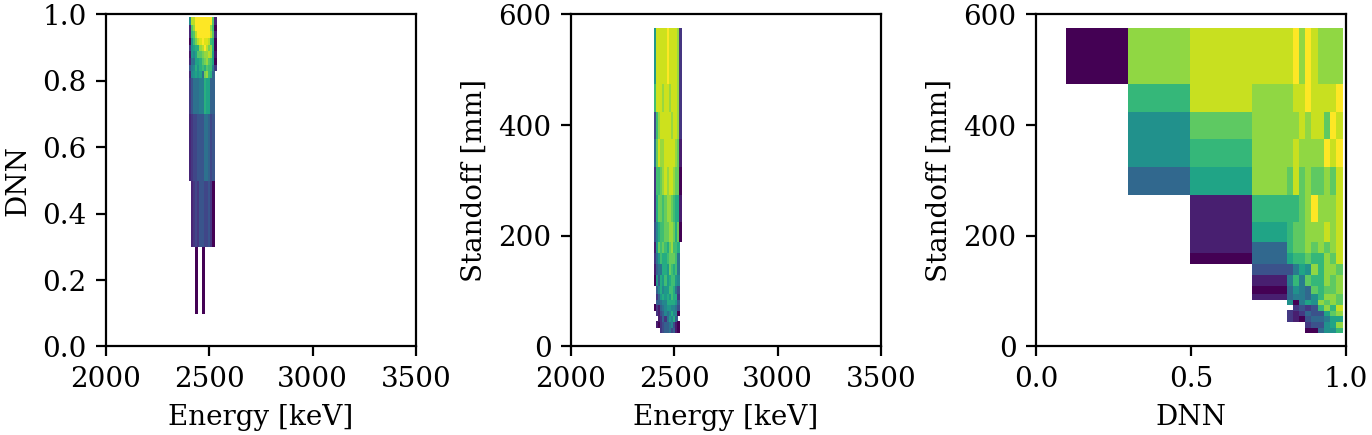

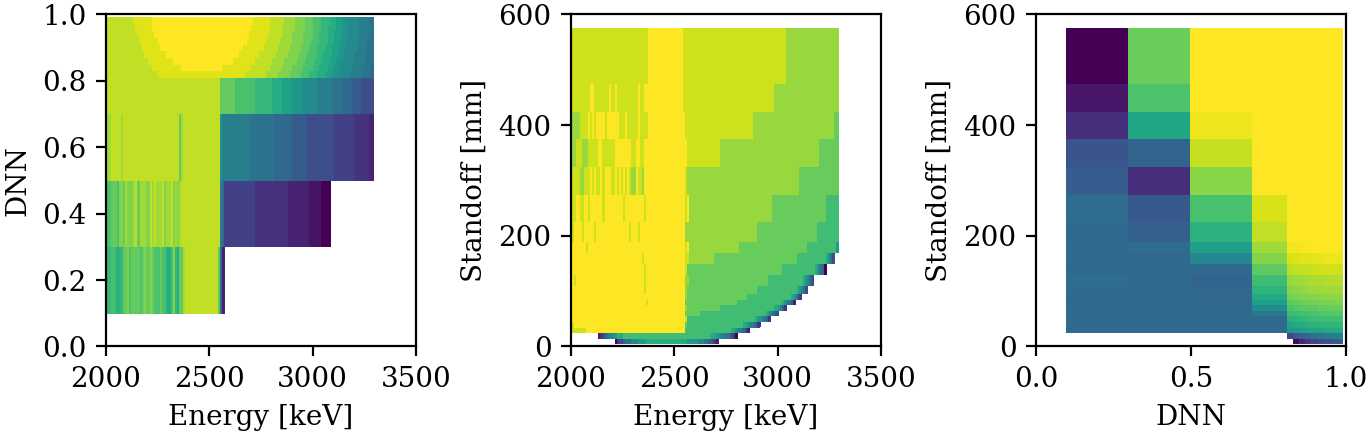

In [188]:
plot_regions_3didx(2000,best_order)
plot_regions_3didx(30000,best_order)

Now that we have a bin order, we can make a 1D histogram of signal and background

In [189]:
def rebin(x, y, be):
  out_vec = np.zeros(len(be)-1)
  for i in range(len(be)-1):
    curr_min, curr_max = be[i], be[i+1]
    gpts = (x >= curr_min) & (x < curr_max)
    out_vec[i] = np.sum( y[gpts] )

  return out_vec


In [190]:
## calculate best order and rebin to optimal size for plotting 
sig_1d = []
bkg_1d = []
tot_1d = []
data_1d = []

rb_size = 280
bin_edges = np.arange(0, len(best_order)-1, rb_size) #np.linspace(0, len(best_order)-1, len(best_order))

for idx in best_order:
  sig_1d.append( sig[idx[0], idx[1], idx[2]] )
  bkg_1d.append( bkg[idx[0], idx[1], idx[2]] )
  tot_1d.append( tot[idx[0], idx[1], idx[2]] )
  data_1d.append( toy_data[idx[0], idx[1], idx[2]] )

sig_1d = np.array(sig_1d)
bkg_1d = np.array(bkg_1d)
tot_1d = np.array(tot_1d)
data_1d = np.array(data_1d)

xvals = np.arange(len(bkg_1d))
rb_bkg_1d = rebin(xvals, bkg_1d, bin_edges)
rb_sig_1d = rebin(xvals, sig_1d, bin_edges)
rb_tot_1d = rebin(xvals, tot_1d, bin_edges)
xvals2 = np.arange(len(rb_bkg_1d))*rb_size

xnorm = 2500 * 16 # normalize total range to 0 to 1

## reverse xvals so that signal is at 1
new_xvals = 1 - xvals2/xnorm

In [191]:
def filled_hist(a,x,y,ybot=[],color='b', leg="", alph=bkg_alpha):
  x2 = np.zeros(2*len(x))
  x2[::2] = x
  x2[1::2] = x

  y2 = np.zeros(2*len(y))
  y2[1::2] = y
  y2[2::2] = y[:-1]

  if(len(ybot) == 0):
    ybot2 = np.zeros_like(y2)
  else:
    ybot2 = np.zeros(2*len(y))
    ybot2[1::2] = ybot
    ybot2[2::2] = ybot[:-1] 

  a.fill_between(x2, ybot2, y2, color=color, alpha = alph, label=leg)

In [192]:
def plot_1d_spec(bb0n_sig, add_toy=False, use_asimov=True, use_default=False, t12_bar=False, filename="", do_legend = False, ylim=None, plot_text ="", add_logo=True, extra_label="", axis_to_use=None, dpi=300, do_title=True, do_sig_bkg=False):
  bb0n_sig_orig = 11.82

  ## hack the normalization for now
  pdf_norm = bb0n_sig_orig/np.sum(sig_1d)
  bb0n_norm = bb0n_sig/bb0n_sig_orig

  if(not axis_to_use):
    if(t12_bar):
      f, (a, abar) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.1}, figsize=(6,3))
    else:
      f = plt.figure(figsize=(5,3))
      a = plt.gca()
  else:
    a = axis_to_use

  if(do_sig_bkg):
    sig_over_bkg = ((rb_sig_1d * bb0n_norm) * pdf_norm)/((rb_bkg_1d) * pdf_norm)
    a.step(new_xvals, sig_over_bkg, 'k', where='post' )
  else:

    a.step(new_xvals, rb_sig_1d * pdf_norm * bb0n_norm, 'darkorange', where='post' )
    filled_hist(a,new_xvals, (rb_sig_1d * bb0n_norm) * pdf_norm, color='darkorange', leg=r'Signal', alph=signal_alpha)
    filled_hist(a,new_xvals, (rb_bkg_1d) * pdf_norm, color='gray', leg=r'Background')
    tot_model = (rb_sig_1d*bb0n_norm + rb_bkg_1d) * pdf_norm
    
    a.step(new_xvals, tot_model, 'k', where='post', label="Total" )

    ## make up the toy
    if(add_toy):
      xc = new_xvals[:-1] + np.diff(new_xvals)/2
      if(use_default):
        rb_data_1d = rebin(xvals, data_1d, bin_edges)
        a.errorbar(xc, rb_data_1d[:-1], yerr=np.sqrt(rb_data_1d[:-1]), fmt='k.', capsize=0)
      elif(use_asimov):
        y_asimov = np.round(tot_model[:-1])
        a.errorbar(xc, y_asimov, yerr=np.sqrt(y_asimov), fmt='k.', capsize=0)
      else:
        rnd_cts = np.zeros(len(xc))
        for j in range(len(xc)):
          rnd_cts[j] = poisson.rvs(tot_model[j])
        a.errorbar(xc, rnd_cts, yerr=np.sqrt(rnd_cts), fmt='k.', capsize=0)

  a.set_xlim(0.94,1)

  if(not ylim):
    lim_max = 2*np.max(rb_sig_1d[(xvals2/xnorm)<1] * pdf_norm)
    max_y = np.max([7, lim_max])
    a.set_ylim(0,max_y )
  else:
    a.set_ylim(0, ylim)
    
  if(t12_bar):
    abar.semilogy([0,0],[1e26, 1e28], 'k')
    abar.set_ylim([1e26, 1e28])
    abar.yaxis.tick_right()
    abar.xaxis.set_ticks([])
    t12 = 0.74e28 / bb0n_norm
    plt.plot(0, t12, 'ro', ms=5)
    plt.text(0.08, 0.74e28, 'nEXO (3$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 0.38e28, 'nEXO (5$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 2.3e26, 'KLZ (2022)', fontsize=8, va='center', color='b')

  if(do_legend):
    handles, labels = a.get_legend_handles_labels()
    order = [1,2,0]
    a.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=9)

  if(do_sig_bkg):
    a.set_ylabel("Signal/Background Ratio (per bin)")
    a.set_xlabel("Combination of Energy + Topology + Standoff (arb. units)")

    ## add cumulative counts at top
    atop = a.twiny()
    new_x_cents = new_xvals[:-1] + np.diff(new_xvals)/2
    gpts = new_x_cents > 0.94
    new_tick_locations = new_x_cents[gpts]
    sig_cts_vec = rb_sig_1d * bb0n_norm * pdf_norm
    cum_sig = np.cumsum(sig_cts_vec) #cumulative signal counts starting from right

    atop.set_xlim(a.get_xlim())
    atop.set_xticks(new_tick_locations)
    atop.set_xticklabels(np.round(cum_sig[:-1][gpts], decimals=1))
    atop.set_xlabel(r"$\leftarrow$ Cumulative expected signal counts")

  else:
    a.set_ylabel("Counts")
    a.set_xlabel("Combination of Energy + Topology + Standoff (arb. units)")
    if(do_title):
      plt.suptitle("nEXO signal/background counts (10 yr)", size=12, x=0.5, y=0.95)


  if(add_logo):
    # read image file
    with mpl.cbook.get_sample_data(r"/content/drive/MyDrive/data/plots/NEXO-final-logo-color-screen.png") as file:
      arr_image = plt.imread(file, format='png')
    axin = a.inset_axes([0.98, 1, 0.12, 0.12])    # create new inset axes in data coordinates
    axin.imshow(arr_image)
    axin.axis('off')  

  if(len(plot_text) > 0):
    a.text(0.995, 0.99, plot_text, va='top', ha='right', transform=a.transAxes)
  if(len(extra_label) > 0 ):
    a.text(0.999, 0.91, extra_label, va='top', ha='right', transform=a.transAxes, color='blue')

  if(len(filename)>0):
    if(".png" in filename or ".gif" in filename):
      plt.savefig(filename, dpi=dpi)
    else:
      plt.savefig(filename)
    plt.close(f)
  elif(not axis_to_use):
    plt.show()

In [193]:
def make_animation(params, filename, add_toy=False, use_asimov=True, do_loop=False, duration=0.15, use_seed=True, make_3panel=False):

  t12_list, yzoom, label_list, extra_label = [], [], [], []
  for p in params:

    curr_t12s = np.logspace(np.log10(p[0]), np.log10(p[1]), p[4])
    curr_yz = np.linspace(p[2], p[3], p[4])
    curr_label = []
    for t in curr_t12s:
      parts = modf(np.log10(t))
      curr_label.append(r"$T_{1/2} = %.1f\times 10^{%d}$ yr"%(10**parts[0], parts[1]))
    curr_el = [p[5]]*p[4]

    t12_list = np.hstack((t12_list, curr_t12s))
    yzoom = np.hstack((yzoom, curr_yz))
    label_list += curr_label
    extra_label += curr_el

    anim_list = []
    for j,(t12, yz, t12_lab, el) in enumerate(zip(t12_list, yzoom, label_list, extra_label)):
      fn = "/content/drive/MyDrive/data/plots/spec_1d_vs_t12/anim_%d.png"%j

      ud = False

      if(use_seed):
        np.random.seed(seed=44) ## fix the random seed to get reproducible plots
                                ## need to decide later whether to force "asimov"-style toys
      if(make_3panel):
        ymax = [yz*0.4, yz*200, yz*0.1]
        make_3panel_plot(bb0n=bb0n_sig * 0.74e28/t12, filename=fn, ebars=add_toy, ymax=ymax, t12_bar=True, plot_text=t12_lab, extra_label=el)  
      else:
        plot_1d_spec(bb0n_sig * 0.74e28/t12, add_toy=add_toy, use_default=ud, t12_bar=True, filename=fn, ylim=yz, plot_text=t12_lab, extra_label=el, dpi=300, use_asimov=use_asimov)
      anim_list.append(fn)

    if(do_loop):
      with imageio.get_writer(filename, mode='I', duration=duration) as writer:
          for j,filenameff in enumerate(anim_list):
                image = imageio.imread(filenameff)
                writer.append_data(image)
    else:
      with imageio.get_writer(filename, mode='I', duration=duration, loop=1) as writer:
          for j,filenameff in enumerate(anim_list):
                image = imageio.imread(filenameff)
                writer.append_data(image)      

KeyboardInterrupt: ignored

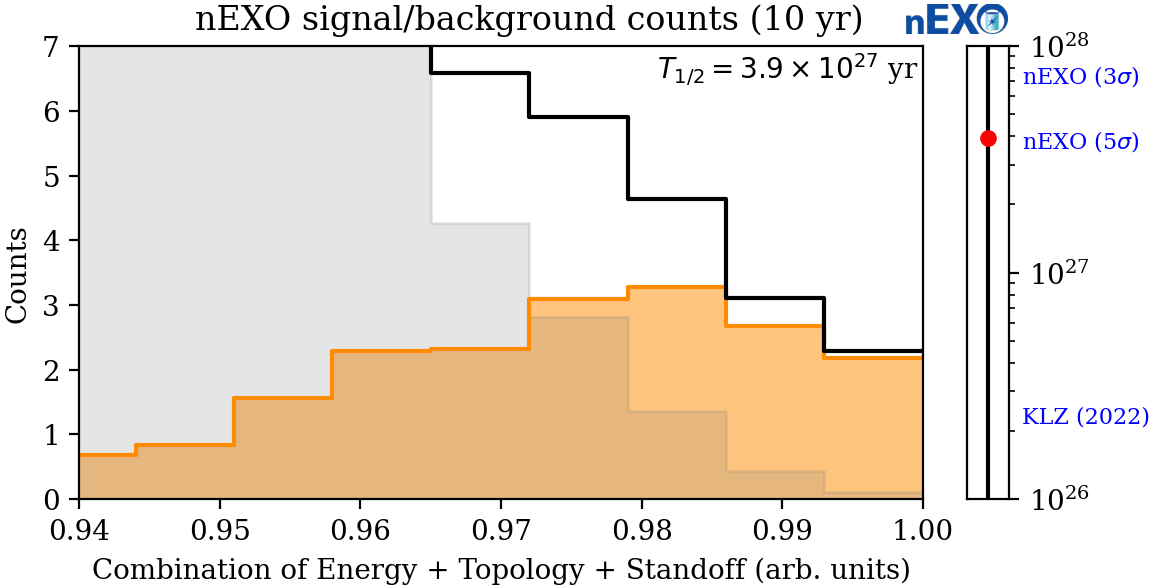

In [194]:
######### make animated 1d spectrum ############

## animated plot versus t12
num_zooms = 20 ## number of frames for zoom out
num_t12s_init = 20 ## number of frames to scan t12 over (nEXO 3-5 sigma)
num_t12s = 20 ## number of frames to scan t12 over (nEXO 5 sigma to KLZ)
y0,y1 = 7, 75 ## ylimits
nreps = 1 ## time to hold initial image

## this is the list and timing for the animation:
## * First scan counts from 3 sigma to 5 sigma
## * Second zoom out axis
## * Third scan counts from 5 sigma to KLZ

####### no error bars
## starting t12, ending t12, start y limit, end y limit, number of frames, extra label
params = [[ 0.74e28, 0.74e28, y0, y0, nreps, r'nEXO (3$\sigma$)'],
          [ 0.74e28, 0.38e28, y0, y0, num_t12s_init, ''],
          [ 0.38e28, 0.38e28, y0, y0, nreps, r'nEXO (5$\sigma$)'],]

fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_no_ebar.gif'
make_animation(params, fn)

### now the zoom out
params = [[ 0.38e28, 0.38e28, y0, y1, num_zooms, r'nEXO (5$\sigma$)'+"\nZooming out"],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_no_ebar_zoomout.gif'
make_animation(params, fn)

params = [[ 0.38e28, 2.3e26, y1, y1, num_t12s, ''],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_no_ebar_zoomout_klz.gif'
make_animation(params, fn)


### with errorbars
## starting t12, ending t12, start y limit, end y limit, number of frames, extra label
params = [[ 0.74e28, 0.74e28, y0, y0, nreps, r'nEXO (3$\sigma$)'],
          [ 0.74e28, 0.38e28, y0, y0, num_t12s_init, ''],
          [ 0.38e28, 0.38e28, y0, y0, nreps, r'nEXO (5$\sigma$)'],]

fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_with_ebar.gif'
make_animation(params, fn, add_toy=True, use_asimov=False)

### now the zoom out
params = [[ 0.38e28, 0.38e28, y0, y1, num_zooms, r'nEXO (5$\sigma$)'+"\nZooming out"],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_with_ebar_zoomout.gif'
make_animation(params, fn, add_toy=True, use_asimov=False)

params = [[ 0.38e28, 2.3e26, y1, y1, num_t12s, ''],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_with_ebar_zoomout_klz.gif'
make_animation(params, fn, add_toy=True, use_asimov=False)

### statistical fluctuations
nstat = 20
params = [[ 0.74e28, 0.74e28, y0, y0, nstat, r'nEXO (3$\sigma$)'],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_stat_fluc_3sig.gif'
make_animation(params, fn, add_toy=True, use_asimov=False, do_loop=True, duration=0.3, use_seed=False)

### statistical fluctuations
params = [[ 0.38e28, 0.38e28, y0, y0, nstat, r'nEXO (5$\sigma$)'],]
fn = '/content/drive/MyDrive/data/plots/spec_1d_vs_t12/spec_1d_vs_t12_anim_stat_fluc_5sig.gif'
make_animation(params, fn, add_toy=True, use_asimov=False, do_loop=True, duration=0.3, use_seed=False)

In [195]:
bb0n_sig = 11.82
plot_1d_spec(bb0n_sig, add_toy=False, t12_bar=True, ylim=7, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", extra_label=r'nEXO (3$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_no_toy_3sig.png")
plot_1d_spec(bb0n_sig * 0.74/0.38, add_toy=False, t12_bar=True, ylim=7, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_no_toy_5sig.png")
plot_1d_spec(bb0n_sig * 0.74/0.38, add_toy=False, t12_bar=True, ylim=75, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)'+"\nZooming out", filename="/content/drive/MyDrive/data/plots/combined_no_toy_5sig_zoom.png")
plot_1d_spec(bb0n_sig * 0.74e2/2.3, add_toy=False, t12_bar=True, ylim=75, plot_text=r"$T_{1/2} = 2.3\times 10^{26}$ yr", extra_label=r'KLZ (2022)', filename="/content/drive/MyDrive/data/plots/combined_no_toy_KLZ.png")

yz=1.5
ymax = [yz*0.4, yz*200, yz*0.1]
make_3panel_plot(bb0n=bb0n_sig, ebars=False, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", extra_label=r'nEXO (3$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_3panel_no_toy_3sig.png")  
make_3panel_plot(bb0n=bb0n_sig* 0.74/0.38, ebars=False, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_3panel_no_toy_5sig.png")
yz=16
ymax = [yz*0.4, yz*200, yz*0.1]
make_3panel_plot(bb0n=bb0n_sig* 0.74/0.38, ebars=False, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)'+"\nZooming out", filename="/content/drive/MyDrive/data/plots/combined_3panel_no_toy_5sig_zoom.png")  
make_3panel_plot(bb0n=bb0n_sig* 0.74e2/2.3, ebars=False, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 2.3\times 10^{26}$ yr", extra_label=r'KLZ (2022)', filename="/content/drive/MyDrive/data/plots/combined_3panel_no_toy_KLZ.png")      

In [209]:
bb0n_sig = 11.82
s = 44
np.random.seed(seed=s)
plot_1d_spec(bb0n_sig, add_toy=True, use_asimov=False, t12_bar=False, add_logo=False, do_legend=True, ylim=5, filename="/content/drive/MyDrive/data/plots/combined_with_toy.png")
np.random.seed(seed=s) #25, 26, 40, 44, 51
plot_1d_spec(bb0n_sig, add_toy=True, use_asimov=False, t12_bar=True, ylim=7, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", extra_label=r'nEXO (3$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_with_toy_3sig.png")
np.random.seed(seed=s) 
plot_1d_spec(bb0n_sig * 0.74/0.38, add_toy=True, use_asimov=False, t12_bar=True, ylim=7, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_with_toy_5sig.png")
np.random.seed(seed=s) 
plot_1d_spec(bb0n_sig * 0.74/0.38, add_toy=True, use_asimov=False, t12_bar=True, ylim=75, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)'+"\nZooming out", filename="/content/drive/MyDrive/data/plots/combined_with_toy_5sig_zoom.png")
np.random.seed(seed=s) 
plot_1d_spec(bb0n_sig * 0.74e2/2.3, add_toy=True, use_asimov=False, t12_bar=True, ylim=75, plot_text=r"$T_{1/2} = 2.3\times 10^{26}$ yr", extra_label=r'KLZ (2022)', filename="/content/drive/MyDrive/data/plots/combined_with_toy_KLZ.png")


yz=1.5
ymax = [yz*0.4, yz*200, yz*0.1]
make_3panel_plot(bb0n=bb0n_sig, ebars=True, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", extra_label=r'nEXO (3$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_3panel_with_toy_3sig.png")  
np.random.seed(seed=s) 
make_3panel_plot(bb0n=bb0n_sig* 0.74/0.38, ebars=True, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)', filename="/content/drive/MyDrive/data/plots/combined_3panel_with_toy_5sig.png")
yz=16
ymax = [yz*0.4, yz*200, yz*0.1]
np.random.seed(seed=s) 
make_3panel_plot(bb0n=bb0n_sig* 0.74/0.38, ebars=True, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", extra_label=r'nEXO (5$\sigma$)'+"\nZooming out", filename="/content/drive/MyDrive/data/plots/combined_3panel_with_toy_5sig_zoom.png")  
np.random.seed(seed=s) 
make_3panel_plot(bb0n=bb0n_sig* 0.74e2/2.3, ebars=True, ymax=ymax, t12_bar=True, plot_text=r"$T_{1/2} = 2.3\times 10^{26}$ yr", extra_label=r'KLZ (2022)', filename="/content/drive/MyDrive/data/plots/combined_3panel_with_toy_KLZ.png")      

In [197]:
plot_1d_spec(11.82, add_toy=False, t12_bar=False, ylim=5, add_logo=False, do_legend=True, filename="/content/drive/MyDrive/data/plots/combined_no_toy.png")
plot_1d_spec(11.82, add_toy=True, t12_bar=False, ylim=5, add_logo=False, filename="/content/drive/MyDrive/data/plots/combined_with_toy.png")

In [198]:
plot_1d_spec(11.82, add_toy=False, t12_bar=False, ylim=12, add_logo=False, do_sig_bkg=True, filename="/content/drive/MyDrive/data/plots/signal_to_bkg_3sig.pdf")

SystemError: ignored

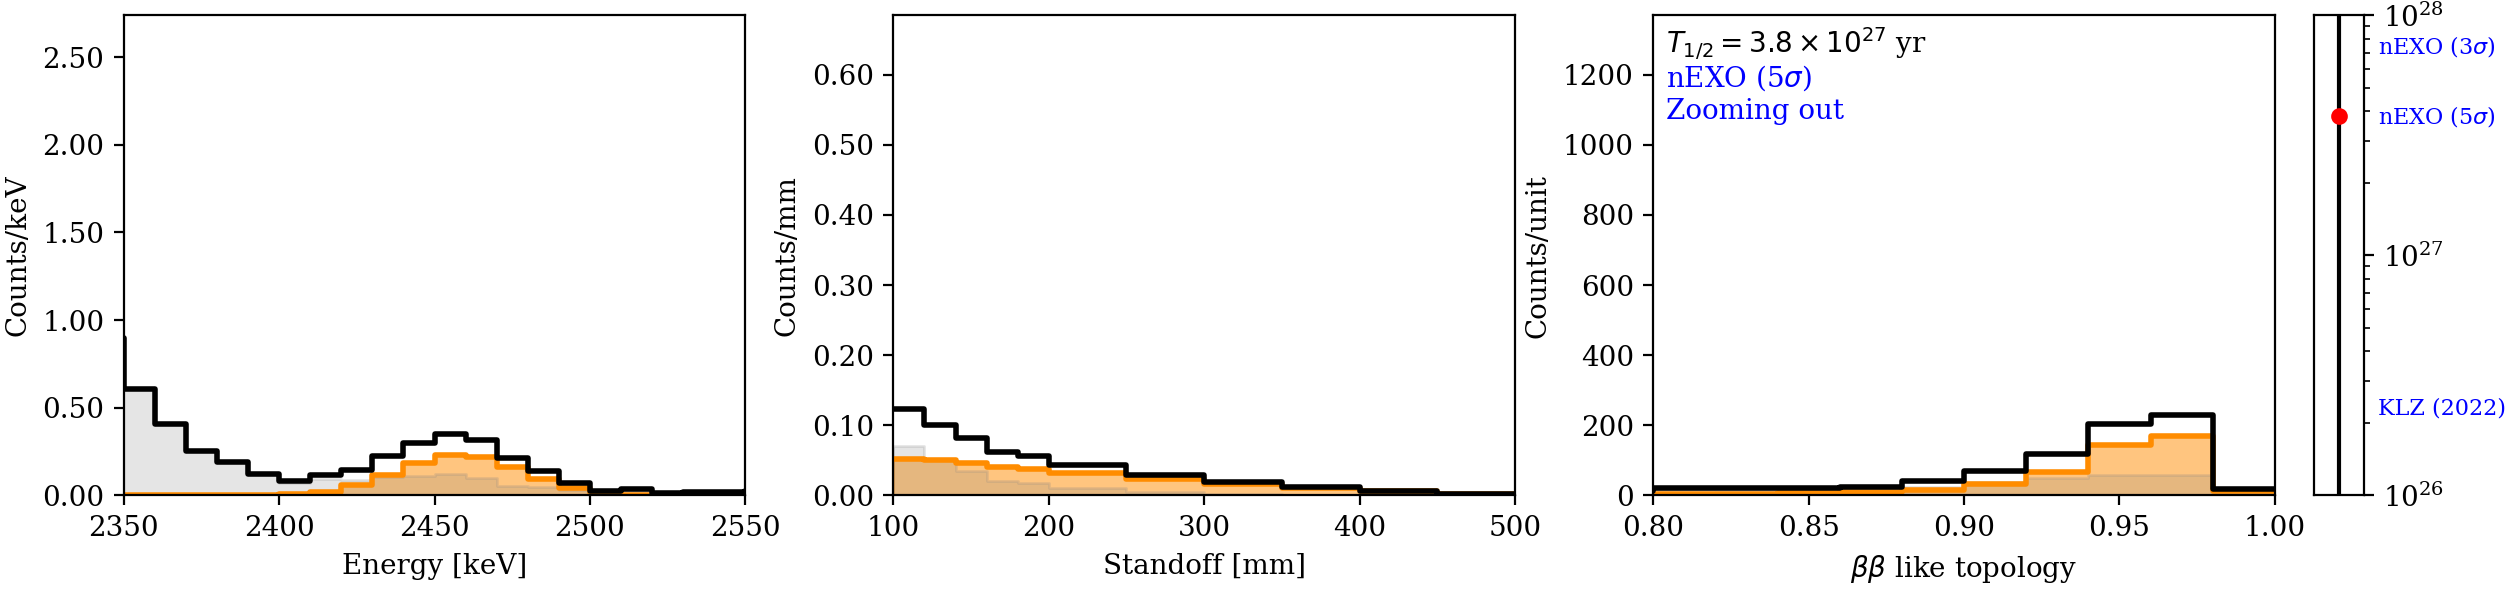

In [200]:
######### make animated 3 panel spectrum ############

## animated plot versus t12
num_zooms = 20 ## number of frames for zoom out
num_t12s_init = 20 ## number of frames to scan t12 over (nEXO 3-5 sigma)
num_t12s = 20 ## number of frames to scan t12 over (nEXO 5 sigma to KLZ)
y0,y1 = 1.5, 16 ## ylimits (this is implemented as a scale factor to the defaults)
nreps = 1 ## time to hold initial image

## this is the list and timing for the animation:
## * First scan counts from 3 sigma to 5 sigma
## * Second zoom out axis
## * Third scan counts from 5 sigma to KLZ

####### no error bars
## starting t12, ending t12, start y limit, end y limit, number of frames, extra label
params = [[ 0.74e28, 0.74e28, y0, y0, nreps, r'nEXO (3$\sigma$)'],
          [ 0.74e28, 0.38e28, y0, y0, num_t12s_init, ''],
          [ 0.38e28, 0.38e28, y0, y0, nreps, r'nEXO (5$\sigma$)'],]

fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_no_ebar.gif'
make_animation(params, fn, make_3panel=True)

### now the zoom out
params = [[ 0.38e28, 0.38e28, y0, y1, num_zooms, r'nEXO (5$\sigma$)'+"\nZooming out"],]
fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_no_ebar_zoomout.gif'
make_animation(params, fn, make_3panel=True)

params = [[ 0.38e28, 2.3e26, y1, y1, num_t12s, ''],]
fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_no_ebar_zoomout_klz.gif'
make_animation(params, fn, make_3panel=True)

## starting t12, ending t12, start y limit, end y limit, number of frames, extra label
params = [[ 0.74e28, 0.74e28, y0, y0, nreps, r'nEXO (3$\sigma$)'],
          [ 0.74e28, 0.38e28, y0, y0, num_t12s_init, ''],
          [ 0.38e28, 0.38e28, y0, y0, nreps, r'nEXO (5$\sigma$)'],]

fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_with_ebar.gif'
make_animation(params, fn, make_3panel=True, add_toy=True, use_seed=True)

### now the zoom out
params = [[ 0.38e28, 0.38e28, y0, y1, num_zooms, r'nEXO (5$\sigma$)'+"\nZooming out"],]
fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_with_ebar_zoomout.gif'
make_animation(params, fn, make_3panel=True, add_toy=True, use_seed=True)

params = [[ 0.38e28, 2.3e26, y1, y1, num_t12s, ''],]
fn = '/content/drive/MyDrive/data/plots/spec_3panel/spec_3panel_anim_with_ebar_zoomout_klz.gif'
make_animation(params, fn, make_3panel=True, add_toy=True, use_seed=True)

In [201]:
plot_regions_3didx_3D(bin_edges[2], best_order, filename="/content/drive/MyDrive/data/plots/low_bg_region.png")

In [202]:
plot_regions_3didx(bin_edges[2],best_order,filename="/content/drive/MyDrive/data/plots/spec_1d_vs_t12/ulb_region.png")

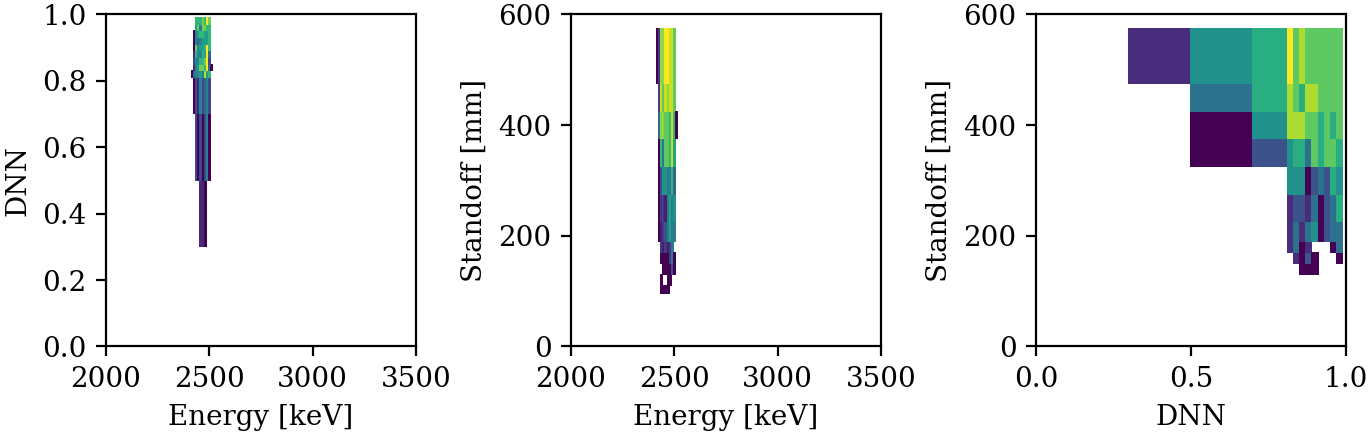

In [203]:
plot_regions_3didx(bin_edges[2],best_order)

In [204]:
def plot_regions_3didx_with_hist_or_roc(bb0n_sig, nbins, idx_list, filename="", do_hist=True, do_3D=True):

  where_mat = np.zeros_like(eng)
  for idx in idx_list[:nbins]:
    where_mat[idx[0], idx[1], idx[2]] = 1

  where_mat_ed = np.sum(where_mat, axis=2)
  where_mat_es = np.sum(where_mat, axis=0)
  where_mat_ds = np.sum(where_mat, axis=1)

  if(do_3D):
    fig = plt.figure(figsize=(12,5))
    G = gridspec.GridSpec(3, 2,  width_ratios=(0.9,1.5), height_ratios=(1, 6, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax1 = fig.add_subplot(G[1,0])
    ax2 = fig.add_subplot(G[:,1], projection='3d')
    ax = [ax1, ax2]
  else:
    fig, ax = plt.subplots (1, 4, figsize=(14,3), gridspec_kw={'width_ratios': [1.5,1,1,1],'wspace':0.5})    

  if(do_hist):
    plot_1d_spec(bb0n_sig, add_toy=False, t12_bar=False, ylim=7, add_logo=False, axis_to_use=ax[0], do_title=False)
    xnorm = 2500 * 16
    line_pos = 1 - nbins/xnorm
    ax[0].plot([line_pos, line_pos], [0,7], 'b--', lw=2)
  else:
    a = ax[0]

    bkg_cdf = np.cumsum(bkg_1d)/np.sum(bkg_1d)
    sig_cdf = np.cumsum(sig_1d)/np.sum(sig_1d)
    a.loglog(bkg_cdf, sig_cdf, 'k', lw=2)
    a.loglog(bkg_cdf[nbins], sig_cdf[nbins], 'ro')
    a.set_ylim(0.01, 1)
    a.set_xlim(1e-6,1)
    a.set_xlabel("Background efficiency")
    a.set_ylabel("Signal efficiency")

  if(do_3D):

    e,d,s=[],[],[]
    for j in range(nbins):
      idx=best_order[j]
      e.append(eng[idx[0], idx[1], idx[2]] )
      d.append(dnn[idx[0], idx[1], idx[2]] )
      s.append(stand[idx[0], idx[1], idx[2]] )
    e, d, s = np.array(e), np.array(d), np.array(s)

    eds = np.vstack((e,d,s)).T

    ## projection for dnn/stand
    xflat = 2000
    h = where_mat_ds
    max_bins = 15
    normalized_map = plt.cm.viridis(h/max_bins)
    normalized_map[h == 0] = np.nan
    p1 = ax[1].plot_surface(xflat, dnn[:,0,:], stand[:,0,:], facecolors=normalized_map, vmin=0, vmax=1, shade=False)

    ## projection for eng/stand
    xflat = 1.2
    h = where_mat_es
    normalized_map = plt.cm.viridis(h/max_bins)
    normalized_map[h == 0] = np.nan
    p2 = ax[1].plot_surface(eng[0,:,:], xflat, stand[0,:,:], facecolors=normalized_map, vmin=0, vmax=1, shade=False)

    ## projection for eng/stand
    xflat = 0*np.ones_like(dnn[:,:,0])
    h = where_mat_ed
    normalized_map = plt.cm.viridis(h/max_bins)
    normalized_map[h == 0] = np.nan
    p3 = ax[1].plot_surface(eng[:,:,0], dnn[:,:,0], xflat, facecolors=normalized_map, vmin=0, vmax=1, shade=False)

    cb = fig.colorbar(p3, shrink=0.5, aspect=10, label="Projected number of bins")
    yl = cb.ax.get_yticks()
    cb.ax.set_yticklabels(np.round(yl*max_bins).astype(int))

    eng_edges, dnn_edges, stand_edges = bins[1], bins[0], bins[2] 

    hull = ConvexHull(eds)
    s = ax[1].plot_trisurf(e, d, s, color='darkorange', triangles=hull.simplices, alpha=0.2, edgecolor='darkorange')

    ax[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax[1].set_yticks([0, 0.5, 1])
    ax[1].set_zticks([0, 200, 400, 600])

    ax[1].set_xlim(2000, 3000)
    ax[1].set_ylim(0,1.2)
    ax[1].set_zlim(0,600)

    ax[1].set_xlabel("Energy [keV]")
    ax[1].set_ylabel("Topology [arb. units]")
    ax[1].set_zlabel("Standoff [mm]")

    ax[1].view_init(30, -55)
    ax[1].dist=11

    #plt.tight_layout()

  else:
    where_mat_ed[where_mat_ed == 0] = np.nan
    where_mat_es[where_mat_es == 0] = np.nan
    where_mat_ds[where_mat_ds == 0] = np.nan

    ax[1].pcolormesh(eng[:,:,0], dnn[:,:,0], where_mat_ed)
    ax[1].set_xlabel("Energy [keV]")
    ax[1].set_ylabel("DNN")

    ax[2].pcolormesh(eng[0,:,:], stand[0,:,:], where_mat_es)
    ax[2].set_xlabel("Energy [keV]")
    ax[2].set_ylabel("Standoff [mm]")

    ax[3].pcolormesh(dnn[:,0,:], stand[:,0,:], where_mat_ds)
    ax[3].set_xlabel("DNN")
    ax[3].set_ylabel("Standoff [mm]")

  #plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0)
  if(len(filename)>0):
    plt.savefig(filename, dpi=100)
    plt.close(fig)
  else:
    plt.show()

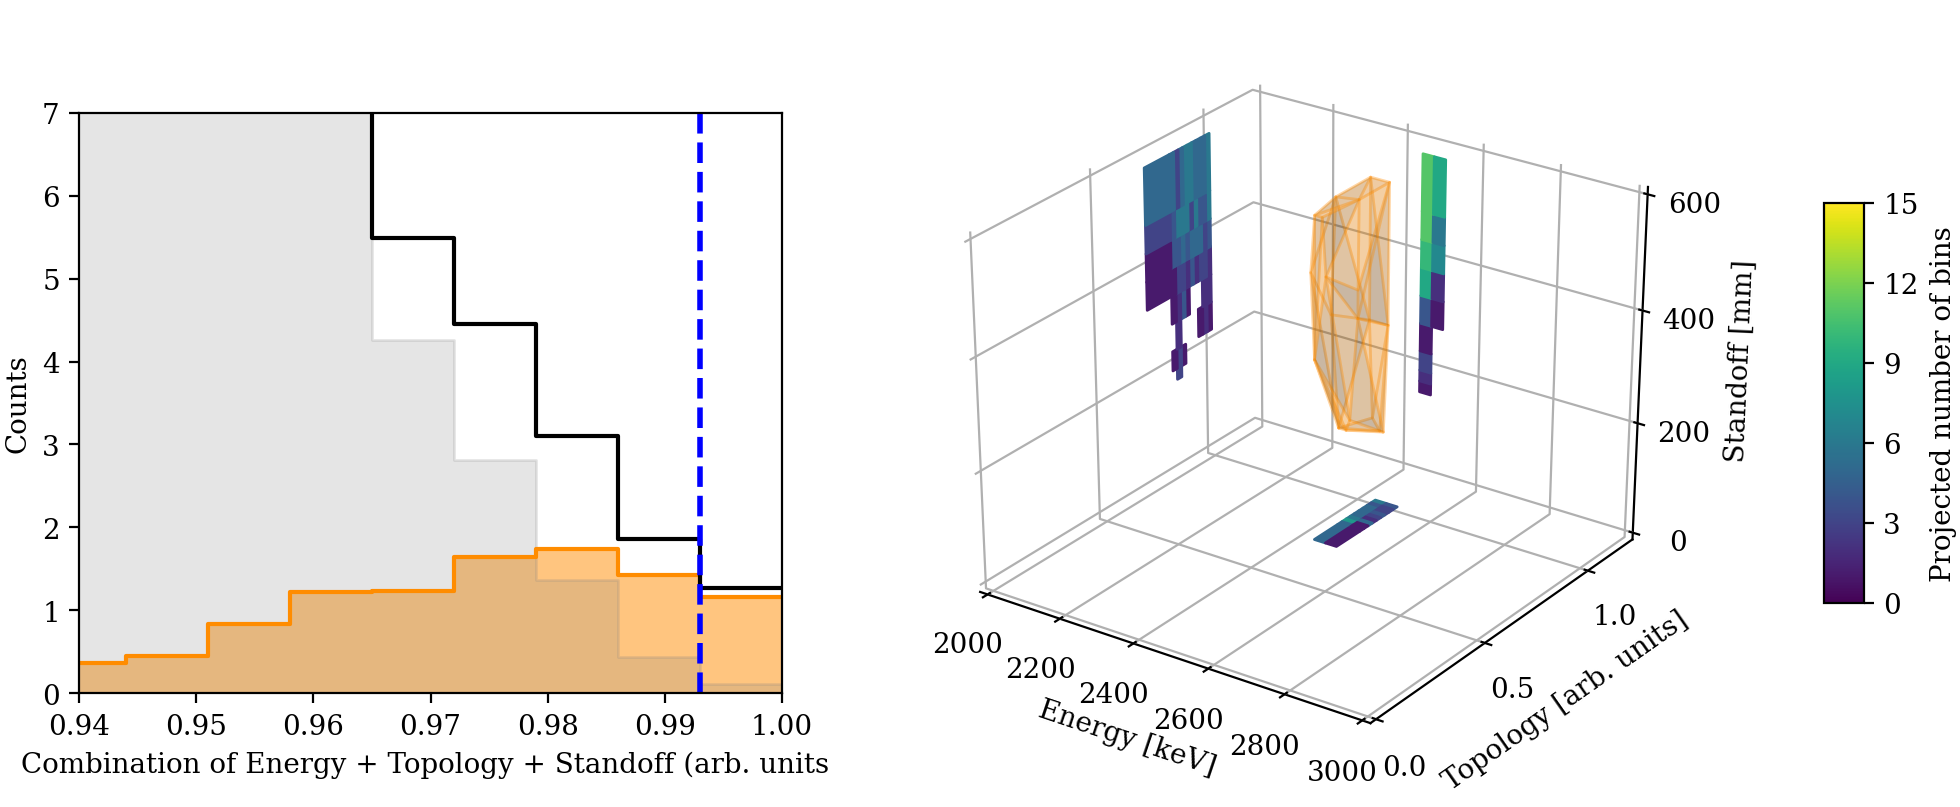

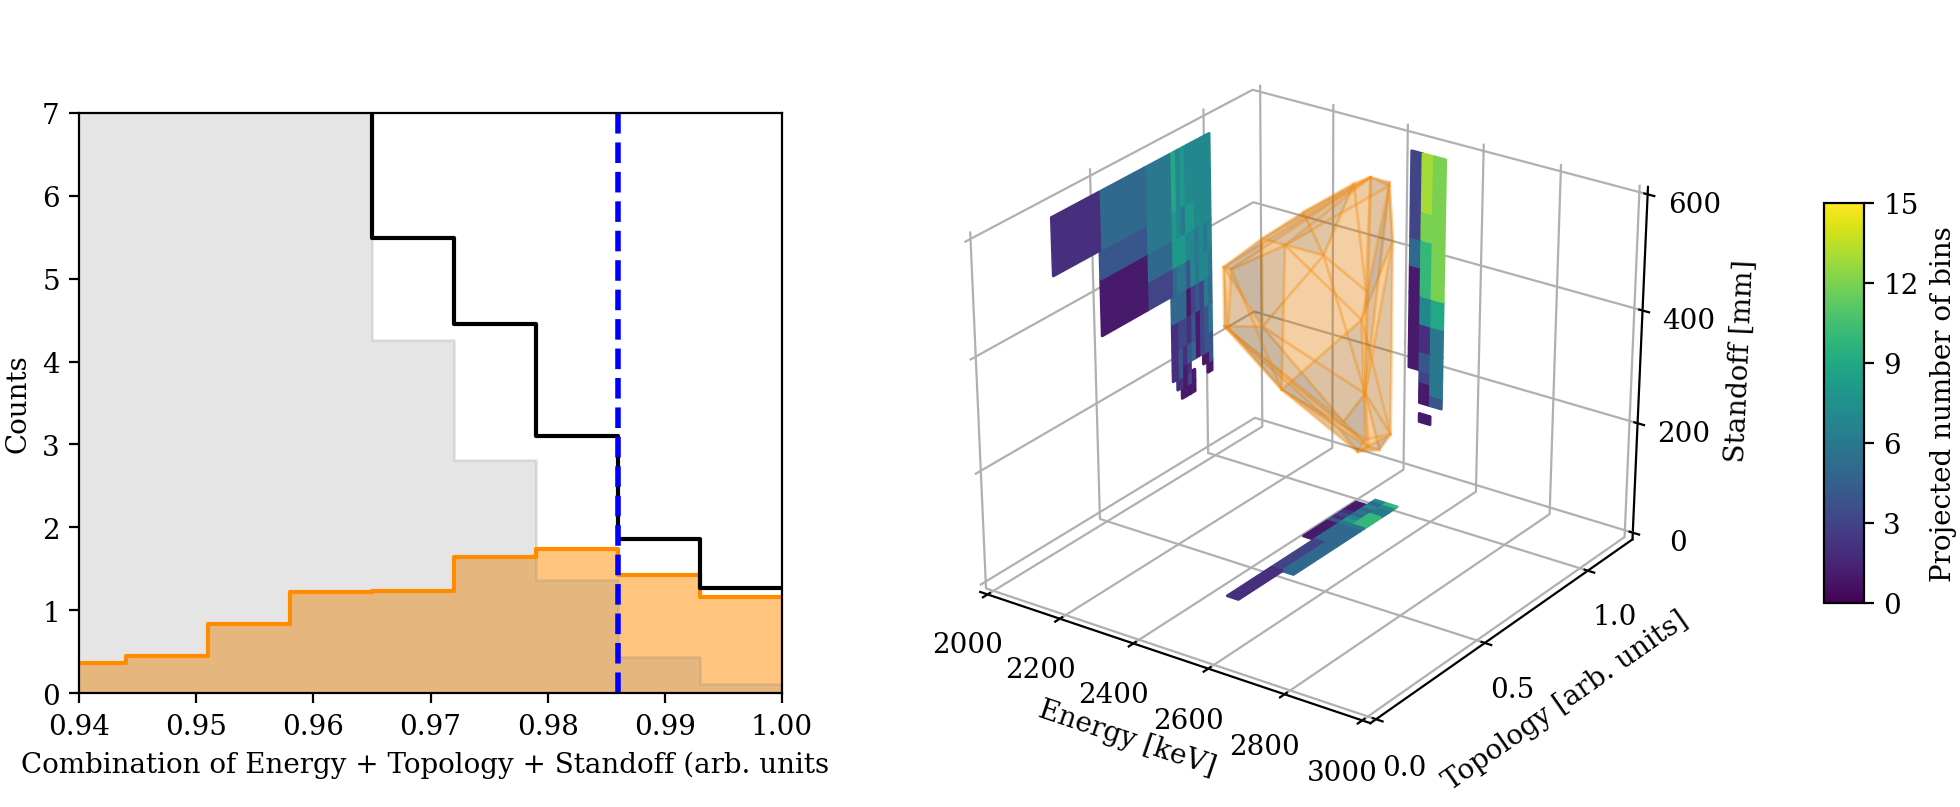

In [205]:
plot_regions_3didx_with_hist_or_roc(bb0n_sig, 280*1, best_order, do_hist=True)
plot_regions_3didx_with_hist_or_roc(bb0n_sig, 280*2, best_order, do_hist=True)

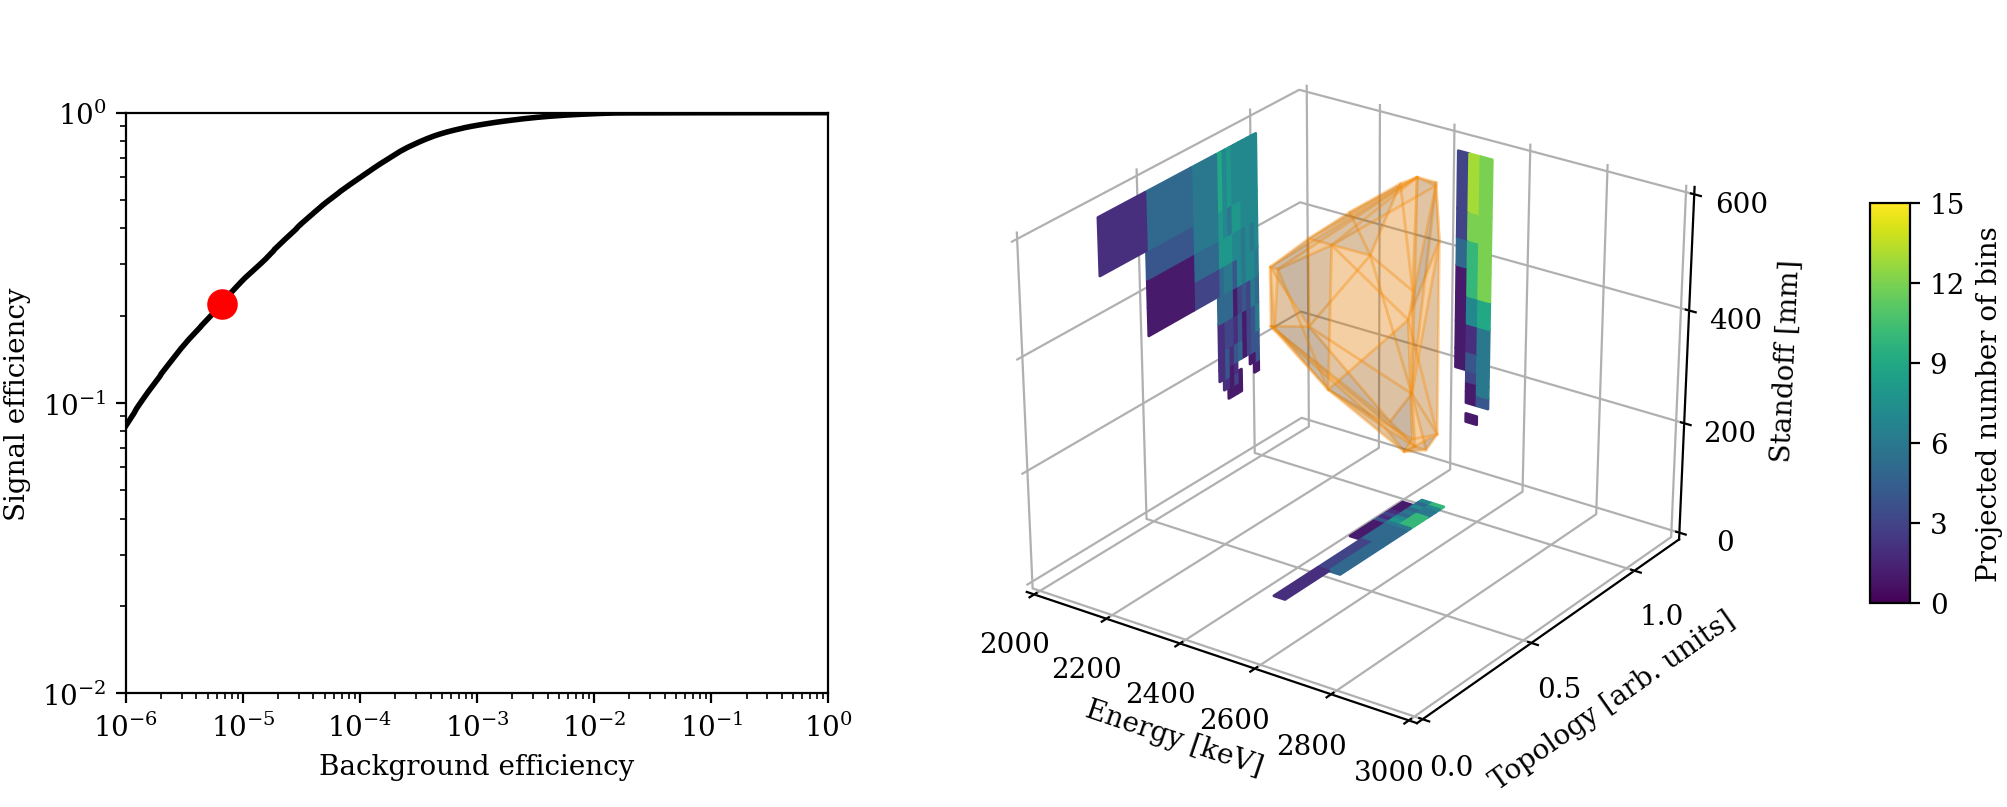

In [206]:
plot_regions_3didx_with_hist_or_roc(bb0n_sig, 280*2, best_order, do_hist=False)

In [207]:
remake_select_anim = True

if(remake_select_anim):
  flist = []

  bins_to_count = (np.linspace(2,np.sqrt(280*9),40).astype(int))**2
  for j,b in enumerate(bins_to_count):
    fn = "/content/drive/MyDrive/data/plots/selection_region/anim_%d.png"%j
    plot_regions_3didx_with_hist_or_roc(bb0n_sig, int(b), best_order, filename=fn, do_hist=True)
    flist.append(fn)

  nreps=10
  with imageio.get_writer('/content/drive/MyDrive/data/plots/selection_region/selection_region_anim.gif', mode='I', duration=0.15) as writer:
      for j,filename in enumerate(flist):
            image = imageio.imread(filename)
            if(j==0 or j==len(flist)-1):
              for k in range(nreps):
                writer.append_data(image)
            else:
              writer.append_data(image)

In [208]:
remake_roc_anim = True

if(remake_roc_anim):
  flist = []

  bins_to_count = (np.linspace(2,np.sqrt(280*9),40).astype(int))**2
  for j,b in enumerate(bins_to_count):
    fn = "/content/drive/MyDrive/data/plots/selection_region_roc/anim_%d.png"%j
    plot_regions_3didx_with_hist_or_roc(bb0n_sig, int(b), best_order, filename=fn, do_hist=False)
    flist.append(fn)

  nreps=10
  with imageio.get_writer('/content/drive/MyDrive/data/plots/selection_region_roc/selection_region_roc_anim.gif', mode='I', duration=0.15) as writer:
      for j,filename in enumerate(flist):
            image = imageio.imread(filename)
            if(j==0 or j==len(flist)-1):
              for k in range(nreps):
                writer.append_data(image)
            else:
              writer.append_data(image)

Now try the 1D version of Soud's plot

In [ ]:
def get_hist_mod(bb0n_sig, plot_comp = False): #modified by Soud
    likelihood2020 = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood2020.AddPDFDataframeToModel(workspace2020_d024.df_group_pdfs, workspace2020_d024.histogram_axis_names)

    initial_values = likelihood2020.GetVariableValues()
    initial_values[likelihood2020.GetVariableIndex('Bb0n')] = bb0n_sig
    likelihood2020.model.UpdateVariables(initial_values)
    likelihood2020.model.GenerateModelDistribution()
    likelihood2020.AddDataset(likelihood2020.model.GenerateDataset())

    bkg_1d = []
    bb0n_1d = []
    all_1d = []
    counts_1d = []
    bins_1d = []

    bkg_2d = []
    bb0n_2d = []



    all_2d = []
    counts_2d = []
    bins_2d = []

    bb0n_3d = []
    bkg_3d = []
    counts_3d = []
    bins_3d = []

    for j in range(3):
        for i, var in enumerate(likelihood2020.model.variable_list):
            #var = likelihood2020.model.variable_list[i]
            
            if 'Num' not in var['Name']:
                print(var['Name'])
                continue

            weight = var['Value']
            cut_pdf = likelihood2020.model.GetSlicedDistribution(cut_dict_list[newidx[j]], var_name=var['Name'], verbose=False)
            cut_pdf_2d = likelihood2020.model.GetSlicedDistribution(cut_dict_list_2d, var_name=var['Name'], verbose=False)
            cut_pdf_3d = likelihood2020.model.GetSlicedDistribution(cut_dict_list_3d, var_name=var['Name'], verbose=False)
            
            if plot_comp == True:
              ### Plotting all components 2D ###
              if j == 0: 
                print(var['Name'])
                fig, ax = plt.subplots(1, 2, figsize=(10,3), gridspec_kw={'wspace':0.26})

                #2D PROJECTIONS, INDEX 0: Energy, 1: DNN, 2: stdoff
                comp_h_2d_dnn_e = hl.Hist((weight*cut_pdf_2d).project([0,1]).bins, (weight*cut_pdf_2d).project([0,1]).values) 
                hl.plot2d(ax[0], comp_h_2d_dnn_e, cbar=True)
                comp_h_2d_e_std = hl.Hist((weight*cut_pdf_2d).project([1,2]).bins, (weight*cut_pdf_2d).project([1,2]).values) 
                hl.plot2d(ax[1], comp_h_2d_e_std, cbar=True)

                ax[0].set_title(var['Name'])
                ax[0].set_ylabel('Energy [keV]')
                ax[0].set_xlabel('DNN Score')
                ax[1].set_xlabel('Energy [keV]')
                ax[1].set_ylabel('Standoff [mm]')
                plt.show()
                ### END ###
            
            #print(type((weight*cut_pdf_2d).project([1,2]).values[0]))


            component_name = ''.join( var['Name'].split('_')[1:] )

            cut_pdf_single_axis = cut_pdf.project([newidx[j]])
            bin_widths = (cut_pdf_single_axis.bins[0][1:] - cut_pdf_single_axis.bins[0][:-1])
            bin_widths = [1.0]*len(bin_widths)

            if i == 0:
                cut_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
                bkg_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
                bb0n_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf.bins)
            
                cut_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)
                bkg_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)
                bb0n_sum_2d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_2d.bins)

                cut_sum_3d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_3d.bins)
                bkg_sum_3d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_3d.bins)
                bb0n_sum_3d = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])], bins=cut_pdf_3d.bins)
            
            cut_sum += (weight * cut_pdf)
            
            cut_sum_2d += (weight * cut_pdf_2d)

            cut_sum_3d += (weight * cut_pdf_3d)

            if 'Bb0n' not in component_name:
                bkg_sum += (weight * cut_pdf)
                bkg_sum_2d += (weight * cut_pdf_2d)
                bkg_sum_3d += (weight * cut_pdf_3d)
            else:
                bb0n_sum += (weight * cut_pdf)
                bb0n_sum_2d += (weight * cut_pdf_2d)
                bb0n_sum_3d += (weight * cut_pdf_3d)
            
        bkg_sum_single_axis = bkg_sum.project([newidx[j]])
        new_bkg_sum_single_axis = hl.Hist(bkg_sum_single_axis.bins, bkg_sum_single_axis.values/bin_widths)

        bb0n_sum_single_axis = bb0n_sum.project([newidx[j]])
        new_bb0n_sum_single_axis = hl.Hist(bb0n_sum_single_axis.bins,bb0n_sum_single_axis.values/bin_widths)

        cut_sum_single_axis = cut_sum.project([newidx[j]])
        new_cut_sum_single_axis = hl.Hist(cut_sum_single_axis.bins,cut_sum_single_axis.values/bin_widths)

        cut_data = likelihood2020.GetSlicedDataset(cut_dict_list[newidx[j]], verbose=False)

        cut_data_1d = cut_data.project([newidx[j]])
        bin_centers = (cut_data_1d.bins[0][:-1]+cut_data_1d.bins[0][1:])/2.0

        if j==0:
            bkg_sum_double_axis = bkg_sum_2d.project([1,0])
            bkg_2d = hl.Hist(bkg_sum_double_axis.bins, bkg_sum_double_axis.values)
            bkg_3d = hl.Hist(bkg_sum_3d.bins, bkg_sum_3d.values)

            bb0n_sum_double_axis = bb0n_sum_2d.project([1,0])
            bb0n_2d = hl.Hist(bb0n_sum_double_axis.bins, bb0n_sum_double_axis.values)
            bb0n_3d = hl.Hist(bb0n_sum_3d.bins, bb0n_sum_3d.values)

            cut_sum_double_axis = cut_sum_2d.project([1,0])
            all_2d = hl.Hist(cut_sum_double_axis.bins, cut_sum_double_axis.values)

        bkg_1d.append(new_bkg_sum_single_axis)
        bb0n_1d.append(new_bb0n_sum_single_axis)
        all_1d.append(new_cut_sum_single_axis)
        counts_1d.append(cut_data_1d)
        bins_1d.append(bin_centers)

    return bkg_1d, bb0n_1d, all_1d, counts_1d, bins_1d, bkg_2d, bb0n_2d, all_2d, bkg_3d, bb0n_3d

In [ ]:
std_cut0p5 = 278.3 #Inner 500 kg
std_cut1 = 201.4 #Inner 1t
std_cut1p5 = 147.3 #Inner 1.5t
std_cut2 = 104.0 #Inner 2t
std_cut2p5 = 68.0 #Inner 2.5t
std_cut3 = 36.3 #Inner 3t
FV = 20.0 #Inner 3281 kg -- Full FV

#For looking at bigger energy spreads
#low_e_cut = 1000.0
#high_e_cut = 3500.0

low_e_cut = 2000.0
high_e_cut = 2800.0

#low_e_cut = 2427.0
#high_e_cut = 2489.0

cut_dict_list = [{'DNN': (0.0,1.), 'Energy (keV)': (2434.,2480.),'Standoff (mm)': (std_cut2, 650.)},\
                 {'DNN': (0.86,1.), 'Energy (keV)': (2000.,2800.), 'Standoff (mm)': (std_cut2, 650.)},\
                {'DNN': (0.86,1.), 'Energy (keV)': (2434.,2480.), 'Standoff (mm)': (std_cut2, 650.)}]

cut_dict_list_2d = {'DNN': (0.0,1.), 'Energy (keV)': (low_e_cut, high_e_cut),'Standoff (mm)': (FV, 650.)}

#cut_dict_list_3d = {'DNN': (0.0,1.), 'Energy (keV)': (low_e_cut, high_e_cut),'Standoff (mm)': (FV, 650.)} 
cut_dict_list_3d = {'DNN': (0.0,1.), 'Energy (keV)': (low_e_cut, high_e_cut),'Standoff (mm)': (FV, 650.)} #Inner 3t

newidx = [1,0,2]


sig = 11.81
q = 2458
bkg_1d, bb0n_1d, all_1d, counts_1d, bins_1d, bkg_2d, bb0n_2d, all_2d, bkg_3d, bb0n_3d = get_hist_mod(sig, plot_comp=False)

In [ ]:
def get_1d_sample(bb0n_norm, seed=1):

  numSigSamples = round(float(bb0n_3d.sum().values) * bb0n_norm)
  numBkgSamples = round(float(bkg_3d.sum().values))
  #print(float(bb0n_3d.sum().values), numBkgSamples)

  dnn, energy, standoff = bb0n_3d.sample(numSigSamples, values=None, kw={'seed': seed})
  dnnb, energyb, standoffb = bkg_3d.sample(numBkgSamples, values=None, w={'seed': seed})

  sig3dhist, sig3dhist_edges = np.histogramdd((dnn,energy,standoff), bins=bins)
  bkg3dhist, bkg3dhist_edges = np.histogramdd((dnnb,energyb,standoffb), bins=bins)

  del dnn, energy, standoff, dnnb, energyb, standoffb

  sig_1d_toy_hist = []
  bkg_1d_toy_hist = []
  for idx in best_order:
    sig_1d_toy_hist.append( sig3dhist[idx[0], idx[1], idx[2]] )
    bkg_1d_toy_hist.append( bkg3dhist[idx[0], idx[1], idx[2]] )

  xvals = np.arange(len(sig_1d_toy_hist))
  new_xvals = 1 - xvals/xnorm

  return sig_1d_toy_hist, bkg_1d_toy_hist, new_xvals

In [217]:
def plot_1d_soud_style_plot(bb0n_sig, t12_bar=True, add_logo=True, make_inset=True, sig_alph=signal_alpha, plot_text="", extra_label="", filename="", dpi=300, seed=1, save_wo_inset=False):
  bb0n_sig_orig = 11.82
  bb0n_norm = bb0n_sig/bb0n_sig_orig

  sig_alph_soud = 0.8

  if(t12_bar):
    f, (a, abar) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.1}, figsize=(6,3))
  else:
    f = plt.figure(figsize=(5,3))
    a = plt.gca()

  s, b, x = get_1d_sample(bb0n_norm, seed=seed)

  filled_hist(a, x, b, color='gray', leg=r'Background')
  filled_hist(a, x, s, color='darkorange', leg=r'Signal', alph=sig_alph_soud)

  a.set_ylabel("Counts")
  a.set_xlabel("Combination of Energy + Topology + Standoff (arb. units)")
  plt.suptitle("Signal/background counts (10 yr)", size=12, x=0.5, y=0.95)

  if(t12_bar):
    abar.semilogy([0,0],[1e26, 1e28], 'k')
    abar.set_ylim([1e26, 1e28])
    abar.yaxis.tick_right()
    abar.xaxis.set_ticks([])
    t12 = 0.74e28 / bb0n_norm
    plt.plot(0, t12, 'ro', ms=5)
    plt.text(0.08, 0.74e28, 'nEXO (3$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 0.38e28, 'nEXO (5$\sigma$)', fontsize=8, va='center', color='b')
    plt.text(0.08, 2.3e26, 'KLZ (2022)', fontsize=8, va='center', color='b')

  if(add_logo):
    # read image file
    with mpl.cbook.get_sample_data(r"/content/drive/MyDrive/data/plots/NEXO-final-logo-color-screen.png") as file:
      arr_image = plt.imread(file, format='png')
    axin = a.inset_axes([0.98, 1, 0.12, 0.12])    # create new inset axes in data coordinates
    axin.imshow(arr_image)
    axin.axis('off')  

  if(len(plot_text) > 0):
    a.text(0.01, 0.28, plot_text, va='bottom', ha='left', transform=a.transAxes)
  if(len(extra_label) > 0 ):
    a.text(0.01, 0.2, extra_label, va='bottom', ha='left', transform=a.transAxes, color='blue')

  a.set_xlim(0.85,1)
  a.set_ylim(0,5)
  a.legend(loc='upper left')

  if(len(filename)>0 and save_wo_inset):
    filename_no_inset = filename[:-4] + "_no_inset" + filename[-4:]
    plt.savefig(filename_no_inset, dpi=dpi)

  if(make_inset):
    lims = [0.98, 1, 0, 2]
    axzoom = a.inset_axes([0.6, 0.525, 0.355, 0.44])  
    filled_hist(axzoom, x, b, color='gray', leg=r'Backgrounds')
    filled_hist(axzoom, x, s, color='darkorange', leg=r'$\beta\beta0\nu$', alph=sig_alph_soud)
    axzoom.set_xlim(lims[:2])
    axzoom.set_ylim(lims[2:])
    rect = patches.Rectangle((lims[0], lims[2]), lims[1]-lims[0], lims[3]-lims[2], linewidth=1, edgecolor='k', facecolor='none', linestyle=":")
    a.add_patch(rect)

  if(len(filename)>0):
    plt.savefig(filename, dpi=dpi)
    plt.close(f)
  else:
    plt.show()

  del s, b, x


In [218]:
## plot initial version
fn = "/content/drive/MyDrive/data/plots/soud_1d/soud_1d.png"
plot_1d_soud_style_plot(11.82, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", filename=fn, save_wo_inset=True)

In [219]:
## first make an animation at the 3 sigma (showing various statistical realizations)

remake_soud3sig_anim = True

ntoys=20

if(remake_soud3sig_anim):
  flist = []

  for j in range(ntoys):
    fn = "/content/drive/MyDrive/data/plots/soud_3sig_anim/anim_%d.png"%j
    plot_1d_soud_style_plot(11.82, plot_text=r"$T_{1/2} = 7.4\times 10^{27}$ yr", filename=fn, dpi=300)
    flist.append(fn)

  nreps=1
  with imageio.get_writer('/content/drive/MyDrive/data/plots/soud_3sig_anim/soud_3sig_anim.gif', mode='I', duration=0.3) as writer:
      for j,filename in enumerate(flist):
            image = imageio.imread(filename)
            if(j==0 or j==len(flist)-1):
              for k in range(nreps):
                writer.append_data(image)
            else:
              writer.append_data(image)

In [220]:
### now 5 sig

if(remake_soud3sig_anim):
  flist = []

  for j in range(ntoys):
    fn = "/content/drive/MyDrive/data/plots/soud_5sig_anim/anim_%d.png"%j
    plot_1d_soud_style_plot(11.82*7.4/3.8, plot_text=r"$T_{1/2} = 3.8\times 10^{27}$ yr", filename=fn, dpi=300)
    flist.append(fn)

  nreps=1
  with imageio.get_writer('/content/drive/MyDrive/data/plots/soud_5sig_anim/soud_5sig_anim.gif', mode='I', duration=0.3) as writer:
      for j,filename in enumerate(flist):
            image = imageio.imread(filename)
            if(j==0 or j==len(flist)-1):
              for k in range(nreps):
                writer.append_data(image)
            else:
              writer.append_data(image)

In [ ]:
remake_1d_vs_t12 = False

## animated plot versus t12
num_zooms = 10 ## number of frames for zoom out
num_t12s_init = 15 ## number of frames to scan t12 over (nEXO 3-5 sigma)
num_t12s = 20 ## number of frames to scan t12 over (nEXO 5 sigma to KLZ)
y0,y1 = 5, 10 ## ylimits
nreps = 20 ## time to hold initial image

## this is the list and timing for the animation:
## * First scan counts from 3 sigma to 5 sigma
## * Second zoom out axis
## * Third scan counts from 5 sigma to KLZ

## starting t12, ending t12, start y limit, end y limit, number of frames, extra label
params = [[ 0.74e28, 0.74e28, y0, y0, nreps, r'nEXO (3$\sigma$)'],
          [ 0.74e28, 0.38e28, y0, y0, num_t12s_init, ''],
          [ 0.38e28, 0.38e28, y0, y0, nreps, r'nEXO (5$\sigma$)'],
          [ 0.38e28, 2.3e26, -1, -1, num_t12s, ''],
          [ 2.3e26, 2.3e26, -1, -1, int(nreps/2), '']]


t12_list, yzoom, label_list, extra_label = [], [], [], []
for p in params:
  curr_t12s = np.logspace(np.log10(p[0]), np.log10(p[1]), p[4])
  curr_yz = np.linspace(p[2], p[3], p[4])
  curr_label = []
  for t in curr_t12s:
    parts = modf(np.log10(t))
    curr_label.append(r"$T_{1/2} = %.1f\times 10^{%d}$ yr"%(10**parts[0], parts[1]))
  curr_el = [p[5]]*p[4]

  t12_list = np.hstack((t12_list, curr_t12s))
  yzoom = np.hstack((yzoom, curr_yz))
  label_list += curr_label
  extra_label += curr_el

if(remake_1d_vs_t12):
  anim_list = []
  for j,(t12, yz, t12_lab, el) in enumerate(zip(t12_list, yzoom, label_list, extra_label)):
    fn = "/content/drive/MyDrive/data/plots/soud_1d_t12/anim_%d.png"%j
    if(yz > 0):
      plot_1d_soud_style_plot(11.82 * 0.74e28/t12, filename=fn, plot_text=t12_lab, extra_label=el, dpi=300)
    else:
      plot_1d_soud_style_plot(11.82 * 0.74e28/t12, filename=fn, plot_text=t12_lab, extra_label=el, dpi=300, make_inset=False)
    anim_list.append(fn)
    gc.collect() ## there's a memory leak somewhere...

  with imageio.get_writer('/content/drive/MyDrive/data/plots/soud_1d_t12/soud_1d_vs_t12_anim.gif', mode='I', duration=0.2) as writer:
      for j,filename in enumerate(anim_list):
            image = imageio.imread(filename)
            writer.append_data(image)